<a href="https://colab.research.google.com/github/Sowmya74/Python/blob/main/ML_Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 4 CSCI 4364/6364 Machine Learning

##**Convolutional Neural Networks**

**Due Date: 11/7/2023, 23:59 ET**

---

**Purpose:**
The purpose of this homework is to familiarize you with **convolutional neural networks** (CNN). We will be using [histology images](https://en.wikipedia.org/wiki/Histology#:~:text=Histology%2C%20also%20known%20as%20microscopic,structures%20visible%20without%20a%20microscope.) used to classify types of  colorectal cancer. You will start with a simple CNN, called LeNet, and apply several improvements made in the AlexNet architecture. You will also get a peek into the CNN layers and channels and how they respond to individual images. Then, you'll implement the GoogLeNet architecture and make modifications to the Inception blocks.

---
**Important!**

* In this homework, you should use [Dive into Deep Learning (d2l)](https://d2l.ai/) as a reference. You may take code snippets that are for **TensorFlow only** and apply them in this homework assignment.


* The models you are working with in this homework are quite advanced and require some time and CPU/GPU resources to execute. You may consider upgrading to [Colab Pro](https://colab.research.google.com/signup) or the pay-as-you-go subscription if you are running out of memory or if your session disconnects after a while. As you proceed through the assignment, take note of the overall **accuracy**, **runtime**, and the **size** (number of parameters) of your models. Finally, give yourself some time to execute the code in the homework.

---
**Submission Instructions:**
This assignment will be done entirely in this Colaboratory notebook, and you will submit your notebook via GWU blackboard. Please embed your code in code blocks and add in comments into the text blocks.

**Grading on the notebook:**
This notebook is worth up to 5% (with up to 3% additional extra credit) of the semester grade, where 3% is completion and full functionality, and 2% is based on comments and descriptions, and well-written and commented Python code, based on the coding standards. The notebook should be fully explained and work in its entirety when you submit it.

**Coding Standards:**
Throughout this course, we will use [Google’s Python Style Guide](https://google.github.io/styleguide/pyguide.html) as the coding standard for homework and project submission. A big part of machine learning in industry is applying good programming practices.


**Name:** Sowmya Vara




**GW ID:** G44613640

In [1]:
#@title Imports
##########################################################
# Always include all imports at the first executable cell.
##########################################################
import numpy as np
import time
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod # Abstract Base Classes for Python
import matplotlib.image as mpimg
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from typing import Dict, Optional, Sequence
import tensorflow as tf
from gc import callbacks
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.callbacks import LearningRateScheduler


#1. Access the colorectal histology dataset

First, download and view the [colorectal histology](https://www.tensorflow.org/datasets/catalog/colorectal_histology)  sample from TFDS, and display the first 9 images and their labels.

Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.

In this assignment, you'll be working on **TensorFlow datasets**, so you may want to review the [API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset). Specifically, you should review `map()`, `shuffle()`, `batch()`, and `load()`.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteLZUN5X/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='colorectal_histology',
    full_name='colorectal_histology/2.0.0',
    description="""
    Classification of textures in colorectal cancer histology. Each example is a 150 x 150 x 3 RGB image of one of 8 classes.
    """,
    homepage='https://zenodo.org/record/53169#.XGZemKwzbmG',
    data_dir=PosixGPath('/tmp/tmpl7o0yjqatfds'),
    file_format=tfrecord,
    download_size=246.14 MiB,
    dataset_size=179.23 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(150, 150, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=5000, num_shards=2>,
    },
    citation="""@article{kather2016mult

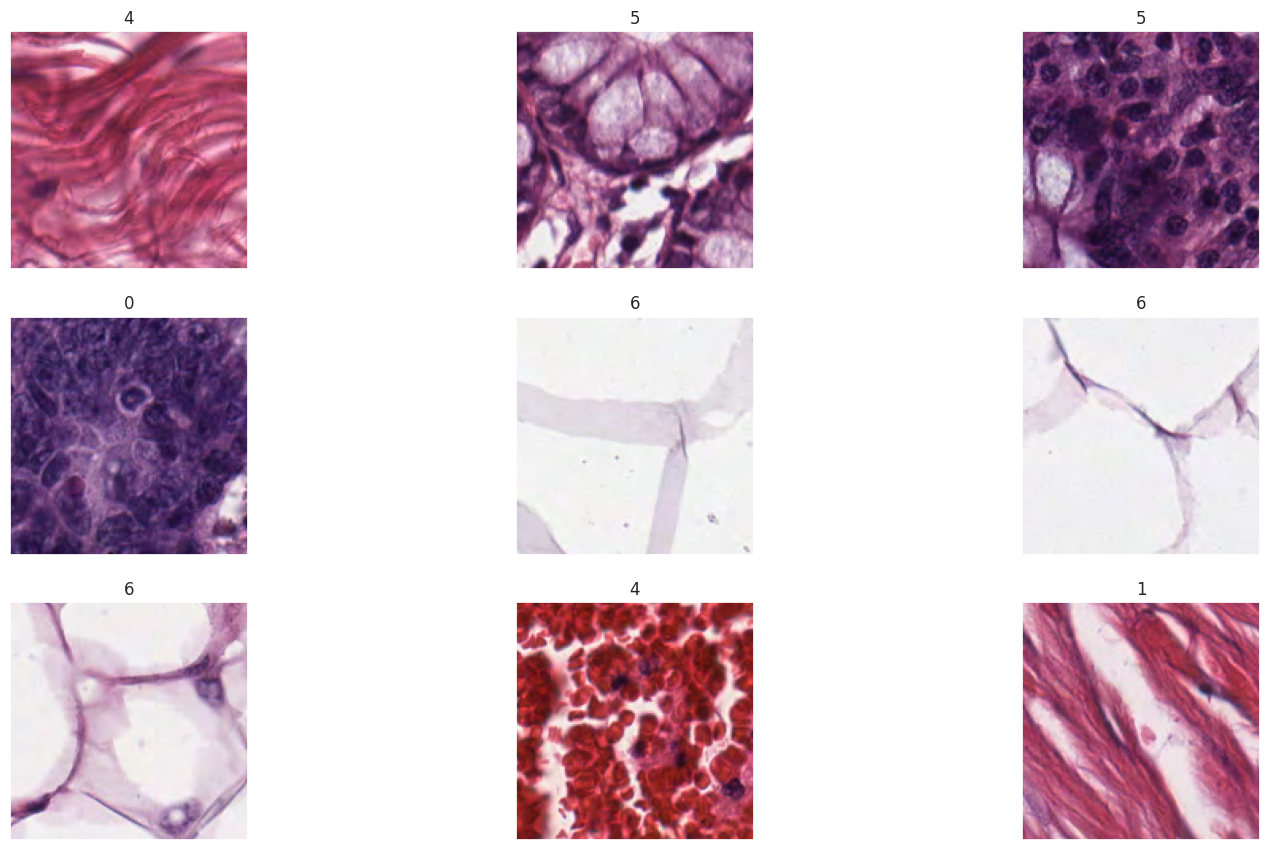

In [2]:
#@title Download the Colorectal Histology image dataset and display examples.

def plot_example(x_raw, y_raw):
  fig, axes = plt.subplots(3, 3)
  i = 0
  for i in range(3):
    for j in range(3):
      imgplot = axes[i,j].imshow(x_raw[i*3 + j], cmap = 'bone')
      axes[i,j].set_title(y_raw[i*3 + j])
      axes[i,j].get_yaxis().set_visible(False)
      axes[i,j].get_xaxis().set_visible(False)
  fig.set_size_inches(18.5, 10.5, forward=True)

## TODO: Implement the split function parameter: 80% train, 10% validation, and 10% test.
(ds_train, ds_val, ds_test), ds_info = tfds.load("colorectal_histology",
                                           split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                           as_supervised=True, with_info=True)
#df = tfds.as_dataframe(ds_train.shuffle(1000).take(1000), ds_info)
df = tfds.as_dataframe(ds_train.take(1000), ds_info)
plot_example(df['image'], df['label'])
print(ds_info)

#2. Define the base class, and define some mapping utilities for TF datasets.
We're making a slight adjustment to the base learning algorithm to take advantage of the TensorFlow dataset structure, rather than using numpy arrays.

We also need to add a few additional methods that will help display layerwise activations in section 5.


In [3]:
#@title Define a base class class for Learning Algorithm

class BaseLearningAlgorithm(ABC):
  """Base class for a Supervised Learning Algorithm."""

  @abstractmethod
  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) ->  tf.keras.callbacks.History:
    """Trains the classifier dataset with a train and validation dataset."""

  @abstractmethod
  def predict(self, x_test: tf.data.Dataset) -> np.array:
    """Predicts one or more examples in the dataset.."""

  @property
  @abstractmethod
  def name(self) -> str:
    """Returns the name of the algorithm."""

  @property
  def layers(self) -> Sequence[tf.keras.layers.Layer]:
    """Returns the layers in the model as a list."""
    raise NotImplementedError()

  @property
  def input(self):
    """Returns the activations per layer, used for displaying activations."""
    raise NotImplementedError()

# Two utilities for modifying the datasets. To be used with dataset.map():
def map_to_categorical(image, label):
    label = tf.one_hot(tf.cast(label, tf.int32), 8)
    label = tf.cast(label, tf.float32)
    return image, label

def normalize_image(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/255.0)
  image = tf.image.resize(image, (150, 150))
  return image, label



We are also making some small adjustments to `train_eval()` from homework 3. We are still generating the confusion matrix and the classification accuracy tables like in homework 3.

In [7]:
def train_eval(learning_algo: BaseLearningAlgorithm, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset, ds_test: tf.data.Dataset):
  """Trains and evaluates the generic model."""

  learning_algo.fit(ds_train, ds_val)

  test_map = ds_test.map(normalize_image)
  for images, labels in test_map.batch(10000):
    y_test  = labels.numpy()
    y_pred =  learning_algo.predict(images)

  mat = confusion_matrix(y_test, y_pred)
  sns.set(rc = {'figure.figsize':(8,8)})
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=['%d' %i for i in range(8)],
              yticklabels=['%d' %i for i in range(8)])
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.title(learning_algo.name)

  print(classification_report(y_test, y_pred,
                              target_names=['%d' %i for i in range(8)]))
# the top 3 classes making errors
  top_3_classes = find_top_error_classes(mat)
  print("Top 3 classes making errors:")
  for cls in top_3_classes:
    print(f"Class {cls[0]} confused with Class {cls[1]} (Error Rate: {cls[2]:.2f})")

In [8]:
def find_top_error_classes(confusion_matrix):
    # Calculating the error rate for each pair of classes
    error_rates = []
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            if i != j:
                error_rate = confusion_matrix[i, j] / confusion_matrix[i].sum()
                error_rates.append((i, j, error_rate))

    # Sorting the error rates and selecting the top 3 classes with the highest error rates
    top_3_classes = sorted(error_rates, key=lambda x: x[2], reverse=True)[:3]
    return top_3_classes

#3. Implement the LeNet architecture as a baseline.


Review [D2L section 6.6](https://classic.d2l.ai/chapter_convolutional-neural-networks/lenet.html)  on the LeNet convolutional neural network. Implement the Tensoflow version of LeNet below. You should include the same TensorFlow architecture and adapt the fit method.


Epoch 1/10
40/40 [==============================] - 2s 14ms/step - loss: 8.0563 - accuracy: 0.2125 - val_loss: 2.0763 - val_accuracy: 0.2560
Epoch 2/10
40/40 [==============================] - 0s 10ms/step - loss: 1.9249 - accuracy: 0.2965 - val_loss: 1.7618 - val_accuracy: 0.3180
Epoch 3/10
40/40 [==============================] - 0s 10ms/step - loss: 1.6986 - accuracy: 0.3478 - val_loss: 1.6460 - val_accuracy: 0.3640
Epoch 4/10
40/40 [==============================] - 0s 10ms/step - loss: 1.4837 - accuracy: 0.4160 - val_loss: 1.5903 - val_accuracy: 0.3580
Epoch 5/10
40/40 [==============================] - 0s 10ms/step - loss: 1.2590 - accuracy: 0.5055 - val_loss: 1.5458 - val_accuracy: 0.3860
Epoch 6/10
40/40 [==============================] - 0s 10ms/step - loss: 1.0750 - accuracy: 0.5713 - val_loss: 1.4697 - val_accuracy: 0.3920
Epoch 7/10
40/40 [==============================] - 0s 10ms/step - loss: 0.8510 - accuracy: 0.6587 - val_loss: 1.5501 - val_accuracy: 0.4400
Epoch 8/10
40

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


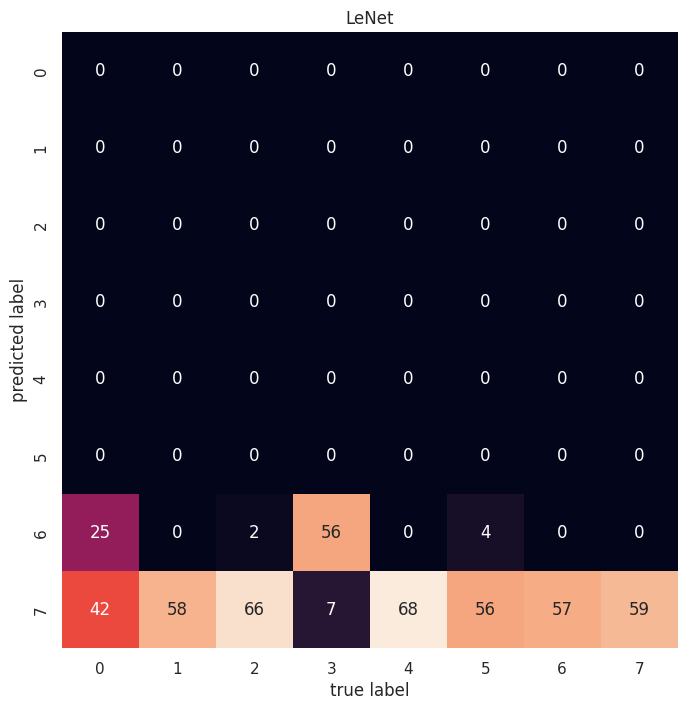

In [12]:
#@title LeNet Classifier

class LeNet(BaseLearningAlgorithm):


  #TODO: Implement the LetNet architecture as an extension class of BaseLearningAlgorithm.
  # Feel free to choose whatever constructor args you like.
  def __init__(self, num_epochs=10, input_shape=(150, 150, 3) ):
      self._num_epochs = num_epochs
      self._model = tf.keras.Sequential([
        # First convolutional layer
        tf.keras.layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Second convolutional layer
        tf.keras.layers.Conv2D(16, (5, 5), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Flatten the output
        tf.keras.layers.Flatten(),

        # Fully connected layer 1
        tf.keras.layers.Dense(120, activation='relu'),

        # Fully connected layer 2
        tf.keras.layers.Dense(84, activation='relu'),

        # Output layer with softmax activation
        tf.keras.layers.Dense(8, activation='softmax')
    ])

      # Compile the model
      self._model.compile(optimizer='adam',
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

  def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) ->  tf.keras.callbacks.History:
    """Trains a model using a train and validation dataset."""

    # TODO create train_batches and val_batches using datset.shuffle(), .batch(), and .map() map_to_categorical, and normalize_image.
    train_batches = ds_train.shuffle(10000).map(map_to_categorical).batch(100)
    val_batches = ds_val.map(map_to_categorical).batch(100)
    history = self._model.fit(train_batches, epochs=self._num_epochs, validation_data = val_batches )
    return history



  def predict(self, x_test:tf.Tensor) :
    """Predicts on an unlabeled sample, X."""
    return np.argmax(self._model.predict(x_test), axis = 1)

  @property
  def name(self) -> str:
    """Returns the name of the algorithm."""
    return "LeNet"

  @property
  def layers(self) -> Sequence[tf.keras.layers.Layer]:
    """Returns the layers in the model as a list."""
    return self._model.layers

  @property
  def input(self):
    """Returns the input at a layer activations per layer."""
    return self._model.input


lenet = LeNet()
%time train_eval(lenet, ds_train, ds_val, ds_test)


##Question 3.1 LeNet performance
(a) What was the overall accuracy and runtime achieved by LeNet?

**Answer:**

The overall accuracy was 0.12 and the wall time which is total runtime for execution was 6.38s by LeNet architecture.

(b) Describe which classes generate the most errors based on the confusion matrix.

**Answer:**

Here, Top 3 classes which are generating the most errors based on the confusion matrix of Lenet architecture was:

Class 1 confused with Class 7,

Class 4 confused with Class 7, and

Class 6 confused with Class 7.


(c) What was the execution runtime?

**Answer:**

The total runtime for execution for lenet architecture was 6.38s.

(d) How many parameters does the model have?

**Answer:**

Total parameters of Lenet are 2233356.



In [13]:
lenet._model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 146, 146, 6)       456       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 73, 73, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 69, 69, 16)        2416      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 34, 34, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 18496)             0         
                                                                 
 dense_12 (Dense)            (None, 120)              

#4. Enhance the baseline LeNet Architecture

Next, review [D2L section 7.1](https://classic.d2l.ai/chapter_convolutional-modern/index.html) and  the improvements the AlexNet made to the LeNet architecture. Similarly, design and implement an architecture with different layers, activation functions, channel counts, filter sizes, and optimizers, learning rates, batch size, and epochs. You should keep the same cetgorical cross-entropy loss, however. Your architecture should yield better accuracy than the LeNet baseline.

Epoch 1/20
125/125 [==============================] - 3s 11ms/step - loss: 3.2961 - accuracy: 0.3050 - val_loss: 1.0267 - val_accuracy: 0.6040
Epoch 2/20
125/125 [==============================] - 1s 10ms/step - loss: 1.2742 - accuracy: 0.4985 - val_loss: 0.8623 - val_accuracy: 0.6680
Epoch 3/20
125/125 [==============================] - 1s 10ms/step - loss: 1.0110 - accuracy: 0.6020 - val_loss: 0.7720 - val_accuracy: 0.6920
Epoch 4/20
125/125 [==============================] - 1s 10ms/step - loss: 0.8904 - accuracy: 0.6463 - val_loss: 0.7031 - val_accuracy: 0.7000
Epoch 5/20
125/125 [==============================] - 1s 10ms/step - loss: 0.8030 - accuracy: 0.6923 - val_loss: 0.6785 - val_accuracy: 0.7020
Epoch 6/20
125/125 [==============================] - 1s 10ms/step - loss: 0.7482 - accuracy: 0.7095 - val_loss: 0.6640 - val_accuracy: 0.7020
Epoch 7/20
125/125 [==============================] - 1s 10ms/step - loss: 0.7054 - accuracy: 0.7272 - val_loss: 0.6326 - val_accuracy: 0.7340

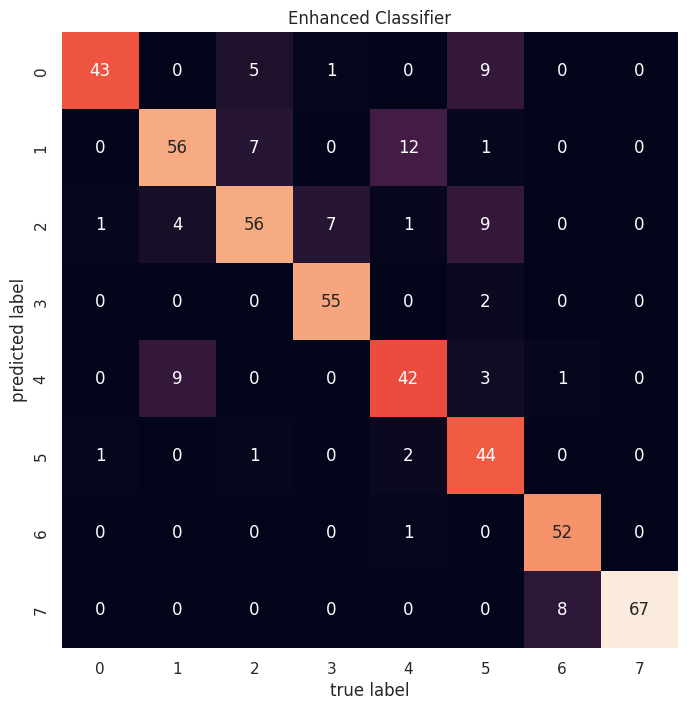

In [16]:
class EnhancedClassifier(LeNet):
    def __init__(self, num_epochs=20, input_shape=(150, 150, 3)):
        super().__init__(num_epochs, input_shape)
        self._model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu',input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),

            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(8, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
        self._model.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) -> tf.keras.callbacks.History:
        """Trains a model using a train and validation dataset."""

        train_batches = ds_train.map(map_to_categorical).batch(32)
        val_batches = ds_val.map(map_to_categorical).batch(32)

        history = self._model.fit(train_batches, epochs=self._num_epochs, validation_data=val_batches)
        return history

    def predict(self, x_test:tf.Tensor) :
        """Predicts on an unlabeled sample, X."""
        return np.argmax(self._model.predict(x_test), axis = 1)

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Enhanced Classifier"

    @property
    def layers(self) -> Sequence[tf.keras.layers.Layer]:
        """Returns the layers in the model as a list."""
        return self._model.layers

    @property
    def input(self):
        """Returns the input at a layer activations per layer."""
        return self._model.input


enhanced_classifier = EnhancedClassifier()
%time train_eval(enhanced_classifier, ds_train, ds_val, ds_test)

In [17]:
enhanced_classifier._model.summary()


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 35, 35, 96)        34944     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 17, 17, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 17, 17, 256)       614656    
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 8, 8, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 384)       

##[OPTIONAL 2% grade points] Early Stopping

Create a keras callback function with early stopping instead of specifying the number of epochs, allowing the model to train until the patience parameter runs out.

Question: How many epochs did your model execute before early stopping quit?

The Enhnaced Classifier model executed for 24 epochs before early stopping quit.

Epoch 1/100
125/125 [==============================] - 4s 13ms/step - loss: 2.6152 - accuracy: 0.3153 - val_loss: 0.9873 - val_accuracy: 0.5680
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 1.1165 - accuracy: 0.5595 - val_loss: 0.7607 - val_accuracy: 0.6920
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.9304 - accuracy: 0.6235 - val_loss: 0.8185 - val_accuracy: 0.6820
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.8123 - accuracy: 0.6852 - val_loss: 0.7239 - val_accuracy: 0.6920
Epoch 5/100
125/125 [==============================] - 1s 10ms/step - loss: 0.7542 - accuracy: 0.7097 - val_loss: 0.6314 - val_accuracy: 0.7400
Epoch 6/100
125/125 [==============================] - 1s 10ms/step - loss: 0.6957 - accuracy: 0.7293 - val_loss: 0.5887 - val_accuracy: 0.7660
Epoch 7/100
125/125 [==============================] - 1s 10ms/step - loss: 0.6728 - accuracy: 0.7487 - val_loss: 0.6633 - val_accuracy:

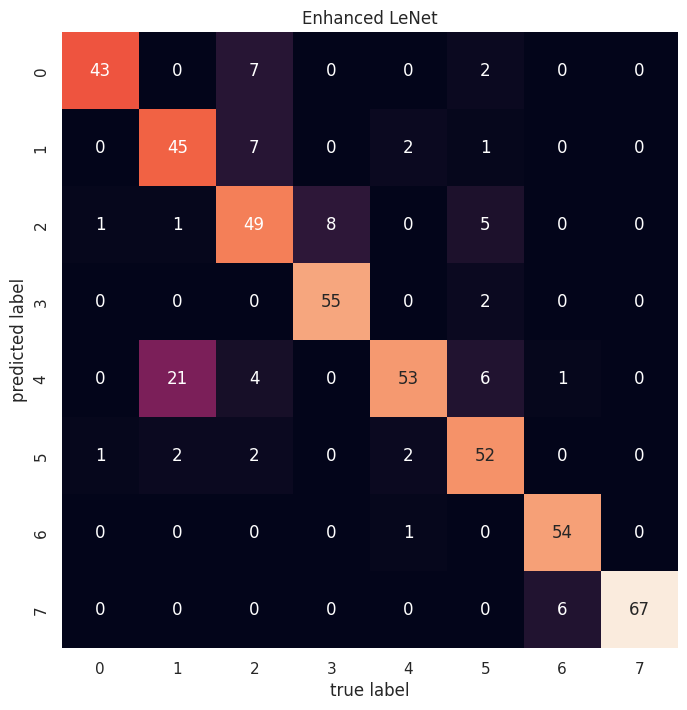

In [21]:
class EnhancedClassifier(LeNet):
     def __init__(self, num_epochs=15, input_shape=(150, 150, 3)):
        super().__init__(num_epochs, input_shape)
        self._model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu',input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),

            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(8, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
        self._model.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
        # Define Early Stopping callback
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

     def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset, num_epochs=100) -> tf.keras.callbacks.History:
        """Trains a model using a train and validation dataset."""

        train_batches = ds_train.map(map_to_categorical).batch(32)
        val_batches = ds_val.map(map_to_categorical).batch(32)

        #history = self._model.fit(train_batches, epochs=self._num_epochs, validation_data=val_batches)
        history = self._model.fit(train_batches, epochs=num_epochs, validation_data=val_batches, callbacks=[self.early_stopping])
        return history

     def predict(self, x_test:tf.Tensor) :
         """Predicts on an unlabeled sample, X."""
         return np.argmax(self._model.predict(x_test), axis = 1)

     @property
     def name(self) -> str:
         """Returns the name of the algorithm."""
         return "Enhanced LeNet"

     @property
     def layers(self) -> Sequence[tf.keras.layers.Layer]:
         """Returns the layers in the model as a list."""
         return self._model.layers

     @property
     def input(self):
         """Returns the input at a layer activations per layer."""
         return self._model.input


enhanced_classifier = EnhancedClassifier()
%time train_eval(enhanced_classifier, ds_train, ds_val, ds_test)

##[OPTIONAL 1% grade point] Learning rate scheduler

Add in a decaying learning [rate scheduler](https://keras.io/api/optimizers/) to the optimizer, replacing the fixed-rate schedule.

What learninging rate decay did you apply?

**Answer**

I have applied learning rate decay value of 0.1 previously which gave performance, 0.81  and then changed the learning rate decay to 0.05 , which gave performance as 0.86 and 0.88 on multiple executions.

What were the parameters?

**Answer**

The total parameters of the enhanced classifier with learning rate scheduler was 30002568.

Were there there any performance improvements?

**Answer**

Yes the performance increased from 0.83 to 0.88 after using learning rate scheduler. In the below code defined the learning rate scheduler that decays the learning rate by a factor of 0.05 for every 40 epochs.



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/100
125/125 [==============================] - 4s 13ms/step - loss: 1.7618 - accuracy: 0.4493 - val_loss: 0.9399 - val_accuracy: 0.5860 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/100
125/125 [==============================] - 1s 11ms/step - loss: 0.9154 - accuracy: 0.6250 - val_loss: 0.7850 - val_accuracy: 0.7180 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/100
125/125 [==============================] - 1s 10ms/step - loss: 0.7827 - accuracy: 0.7005 - val_loss: 0.7281 - val_accuracy: 0.7140 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/100
125/125 [==============================] - 1s 10ms/step - loss: 0.7005 - accuracy: 0.7283 - val_loss: 0.6701 - val_accuracy: 0.7220 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler sett

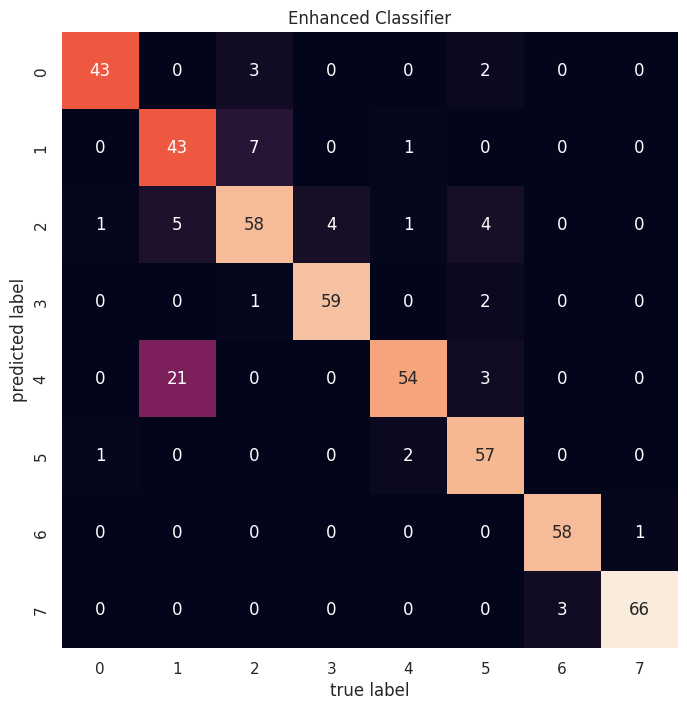

In [22]:
class EnhancedClassifier(LeNet):
    def __init__(self,input_shape=(150, 150, 3)):
        super().__init__(input_shape)
        self._model = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4,
                               activation='relu',input_shape=input_shape),
            tf.keras.layers.MaxPooling2D(pool_size=3, strides=2),
            tf.keras.layers.Conv2D(filters=256, kernel_size=5, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),

            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=384, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding='same',
                               activation='relu'),
            tf.keras.layers.MaxPool2D(pool_size=3, strides=2),
            tf.keras.layers.Flatten(),

            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4096, activation='relu'),
            tf.keras.layers.Dropout(0.5),

            tf.keras.layers.Dense(8, activation='softmax')
        ])
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self._model.compile(optimizer=optimizer,
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])
        # Define Early Stopping callback
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        def lr_scheduler(epoch, lr):
            decay_rate = 0.05
            decay_step = 40
            if epoch % decay_step == 0 and epoch:
                return lr * decay_rate
            return lr
        self.lr_schedule = LearningRateScheduler(lr_scheduler, verbose=1)

    def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset, num_epochs=100) -> tf.keras.callbacks.History:
        """Trains a model using a train and validation dataset."""

        train_batches = ds_train.map(map_to_categorical).batch(32)
        val_batches = ds_val.map(map_to_categorical).batch(32)

        #history = self._model.fit(train_batches, epochs=self._num_epochs, validation_data=val_batches)
        history = self._model.fit(train_batches, epochs=num_epochs, validation_data=val_batches, callbacks=[self.early_stopping, self.lr_schedule])
        return history

    def predict(self, x_test:tf.Tensor) :
        """Predicts on an unlabeled sample, X."""
        return np.argmax(self._model.predict(x_test), axis = 1)

    @property
    def name(self) -> str:
        """Returns the name of the algorithm."""
        return "Enhanced Classifier"

    @property
    def layers(self) -> Sequence[tf.keras.layers.Layer]:
        """Returns the layers in the model as a list."""
        return self._model.layers

    @property
    def input(self):
        """Returns the input at a layer activations per layer."""
        return self._model.input


enhanced_classifier = EnhancedClassifier()
%time train_eval(enhanced_classifier, ds_train, ds_val, ds_test)

In [18]:
enhanced_classifier._model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 35, 35, 96)        34944     
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 17, 17, 96)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 17, 17, 256)       614656    
                                                                 
 max_pooling2d_31 (MaxPooli  (None, 8, 8, 256)         0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 8, 8, 384)         885120    
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 384)       

##Question 4.1 Enhanced Classifier performance
(a) What was the overall accuracy and runtime achieved by your enhanced architecture inspired by AlexNet?

**Answer**

Overall accuracy was 0.83 and the wall time which is the total runtime for execution was 27.2s by Enhanced classifier inspired by AlexNet architecture.

(b) Describe which classes generate the most errors based on the confusion matrix.

**Answer**

Based on the enhanced classifier confusion matrix, the most errors causing classes were

Class 4 confused with Class 1 (Error Rate: 0.21),

Class 5 confused with Class 0 (Error Rate: 0.13), and

Class 5 confused with Class 2 (Error Rate: 0.13)

(c) What was the execution runtime?

**Answer**

The total runtime for execution was 27.2s by Enhanced classifier inspired by AlexNet architecture.

(d) How many parameters does your model have?

**Answer**

Total parameters for the enhanced classifier model are 30002568.

#5. Investigate the activations of the each layer and channel.

In this section. we'll explore the activations at each layer in your enhanced CNN by plotting them and inspecting the activation images for example images, layers, and channels.

We'll create a series of images that are grouped by layer, channel, and image. Recall that a layer usually has multiple channels, and each channel projects an output image for an input image.

Use the function `plot_activations()` to generate multiple activation plots. Note that before each new layer, the function shows the raw input image to make the visual inspection a little easier.

1/1 [==============================] - 0s 99ms/step


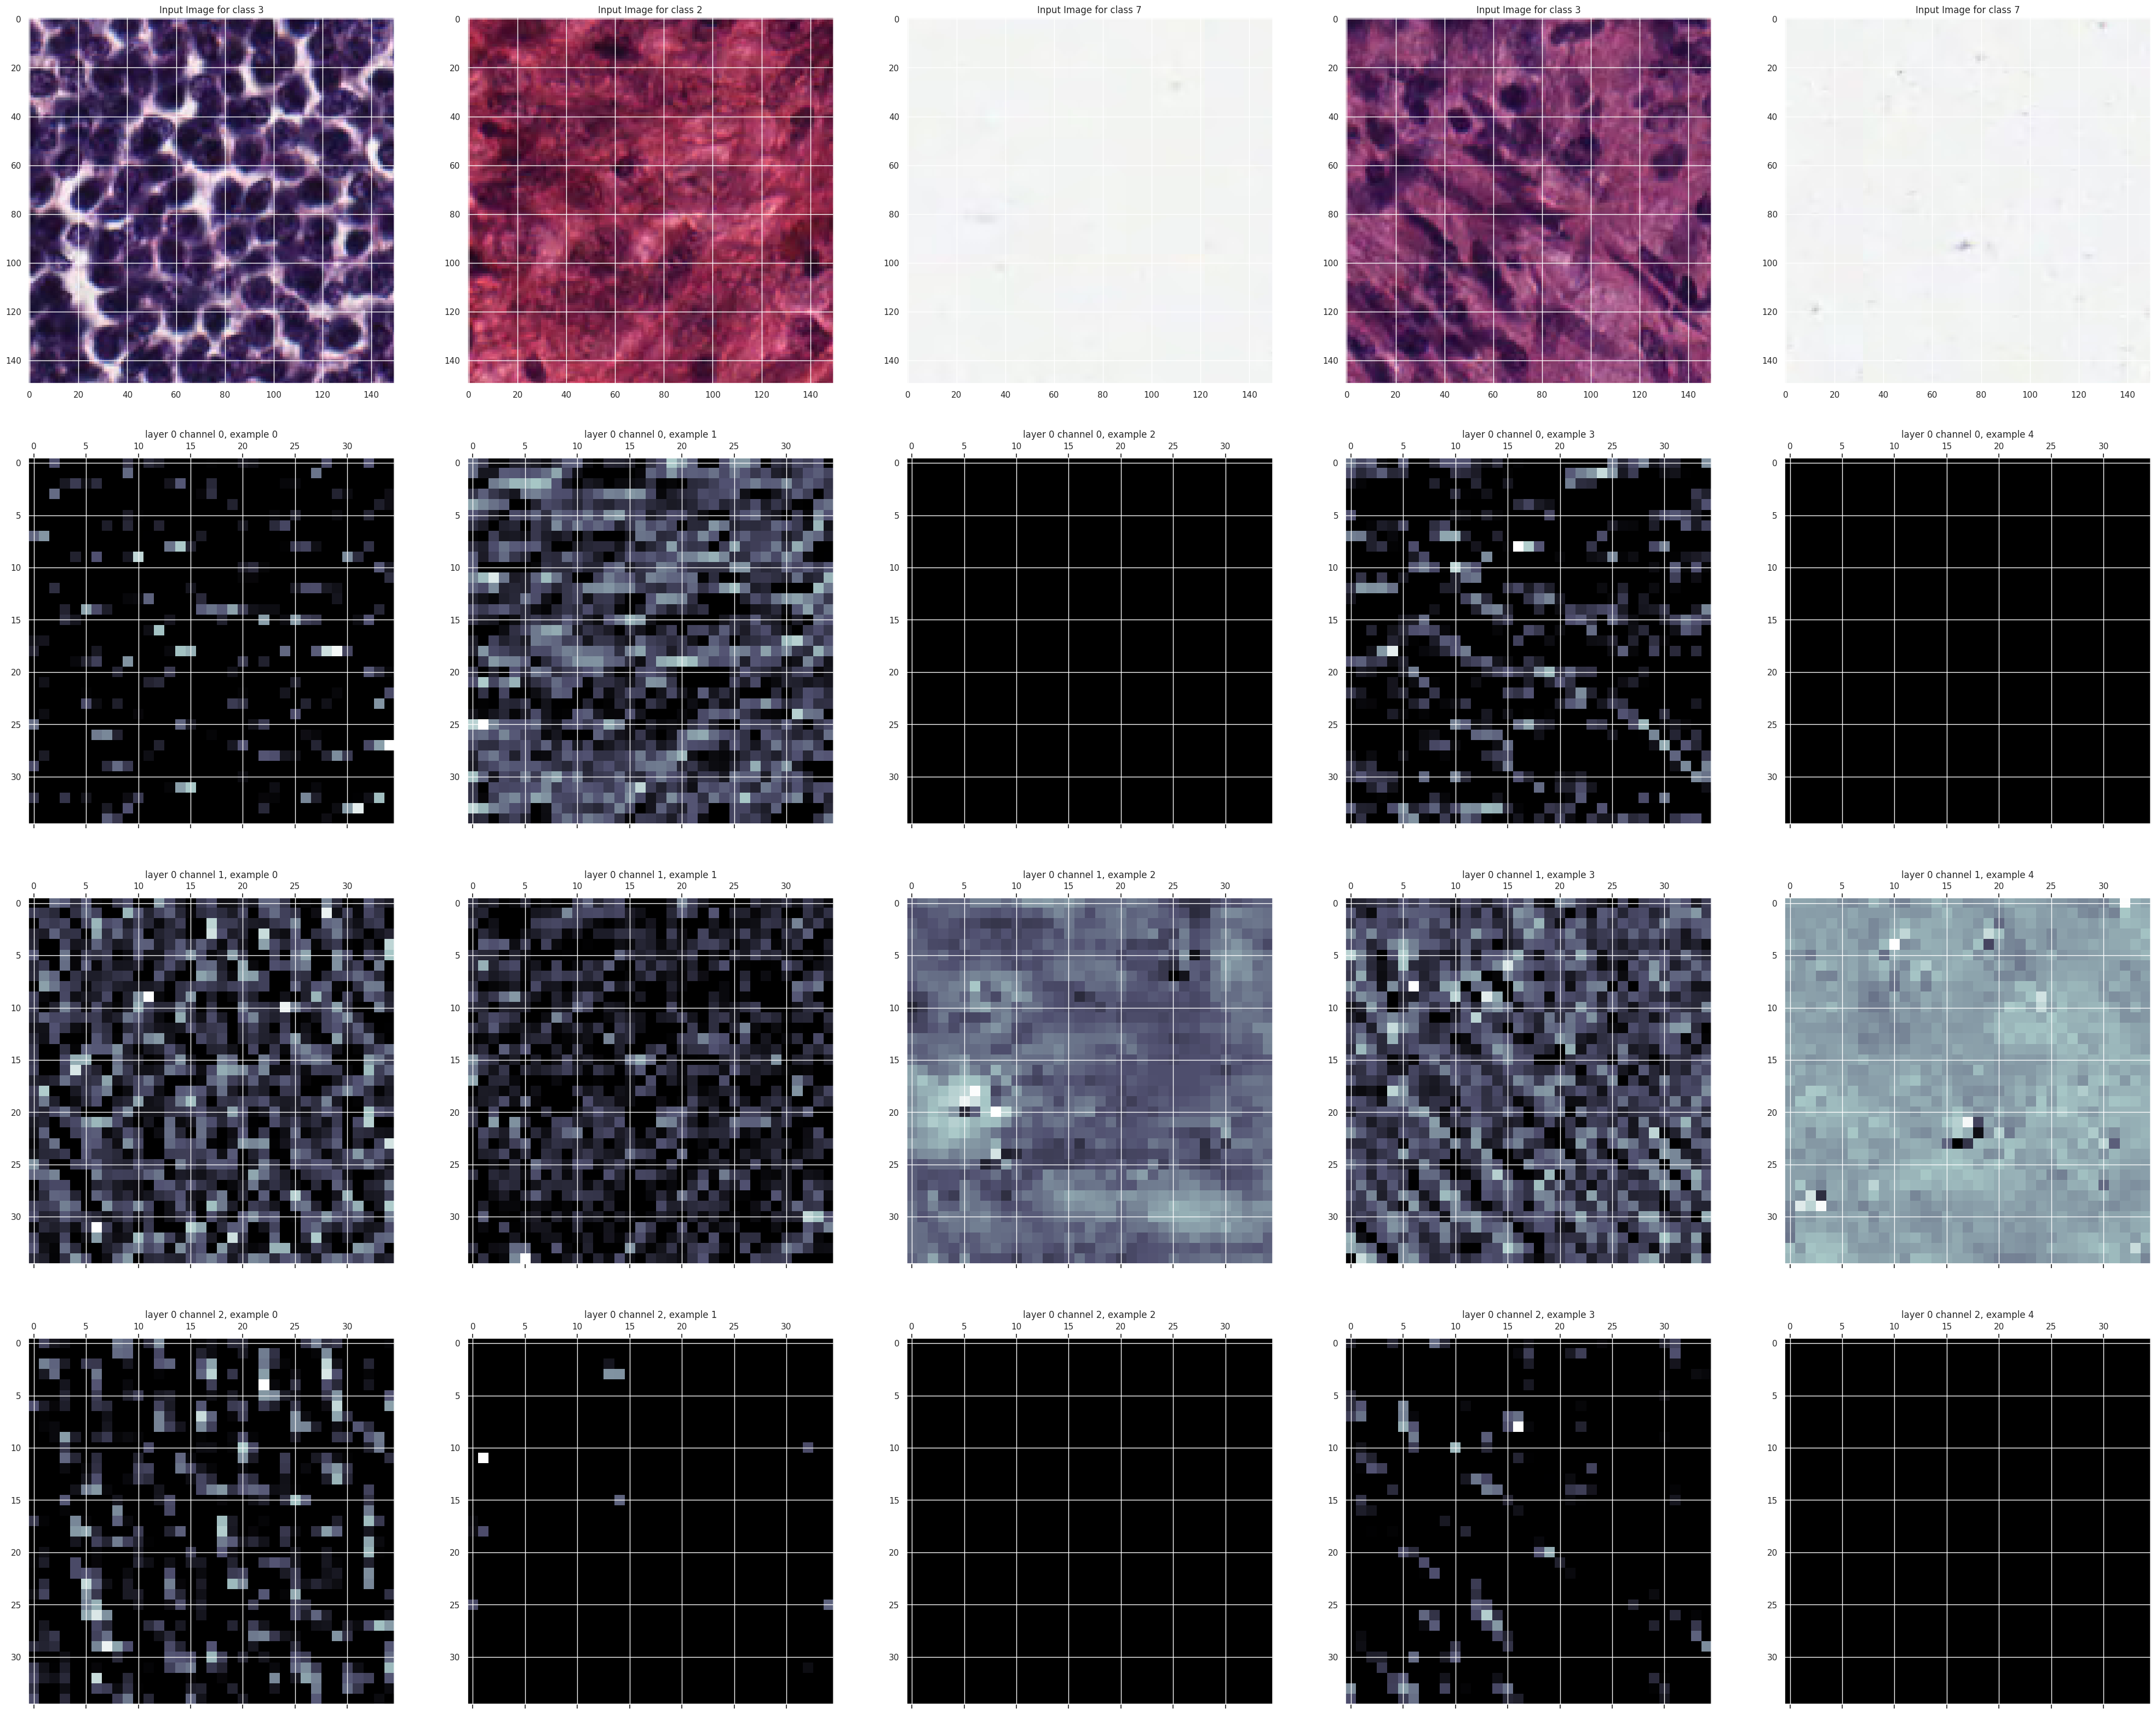

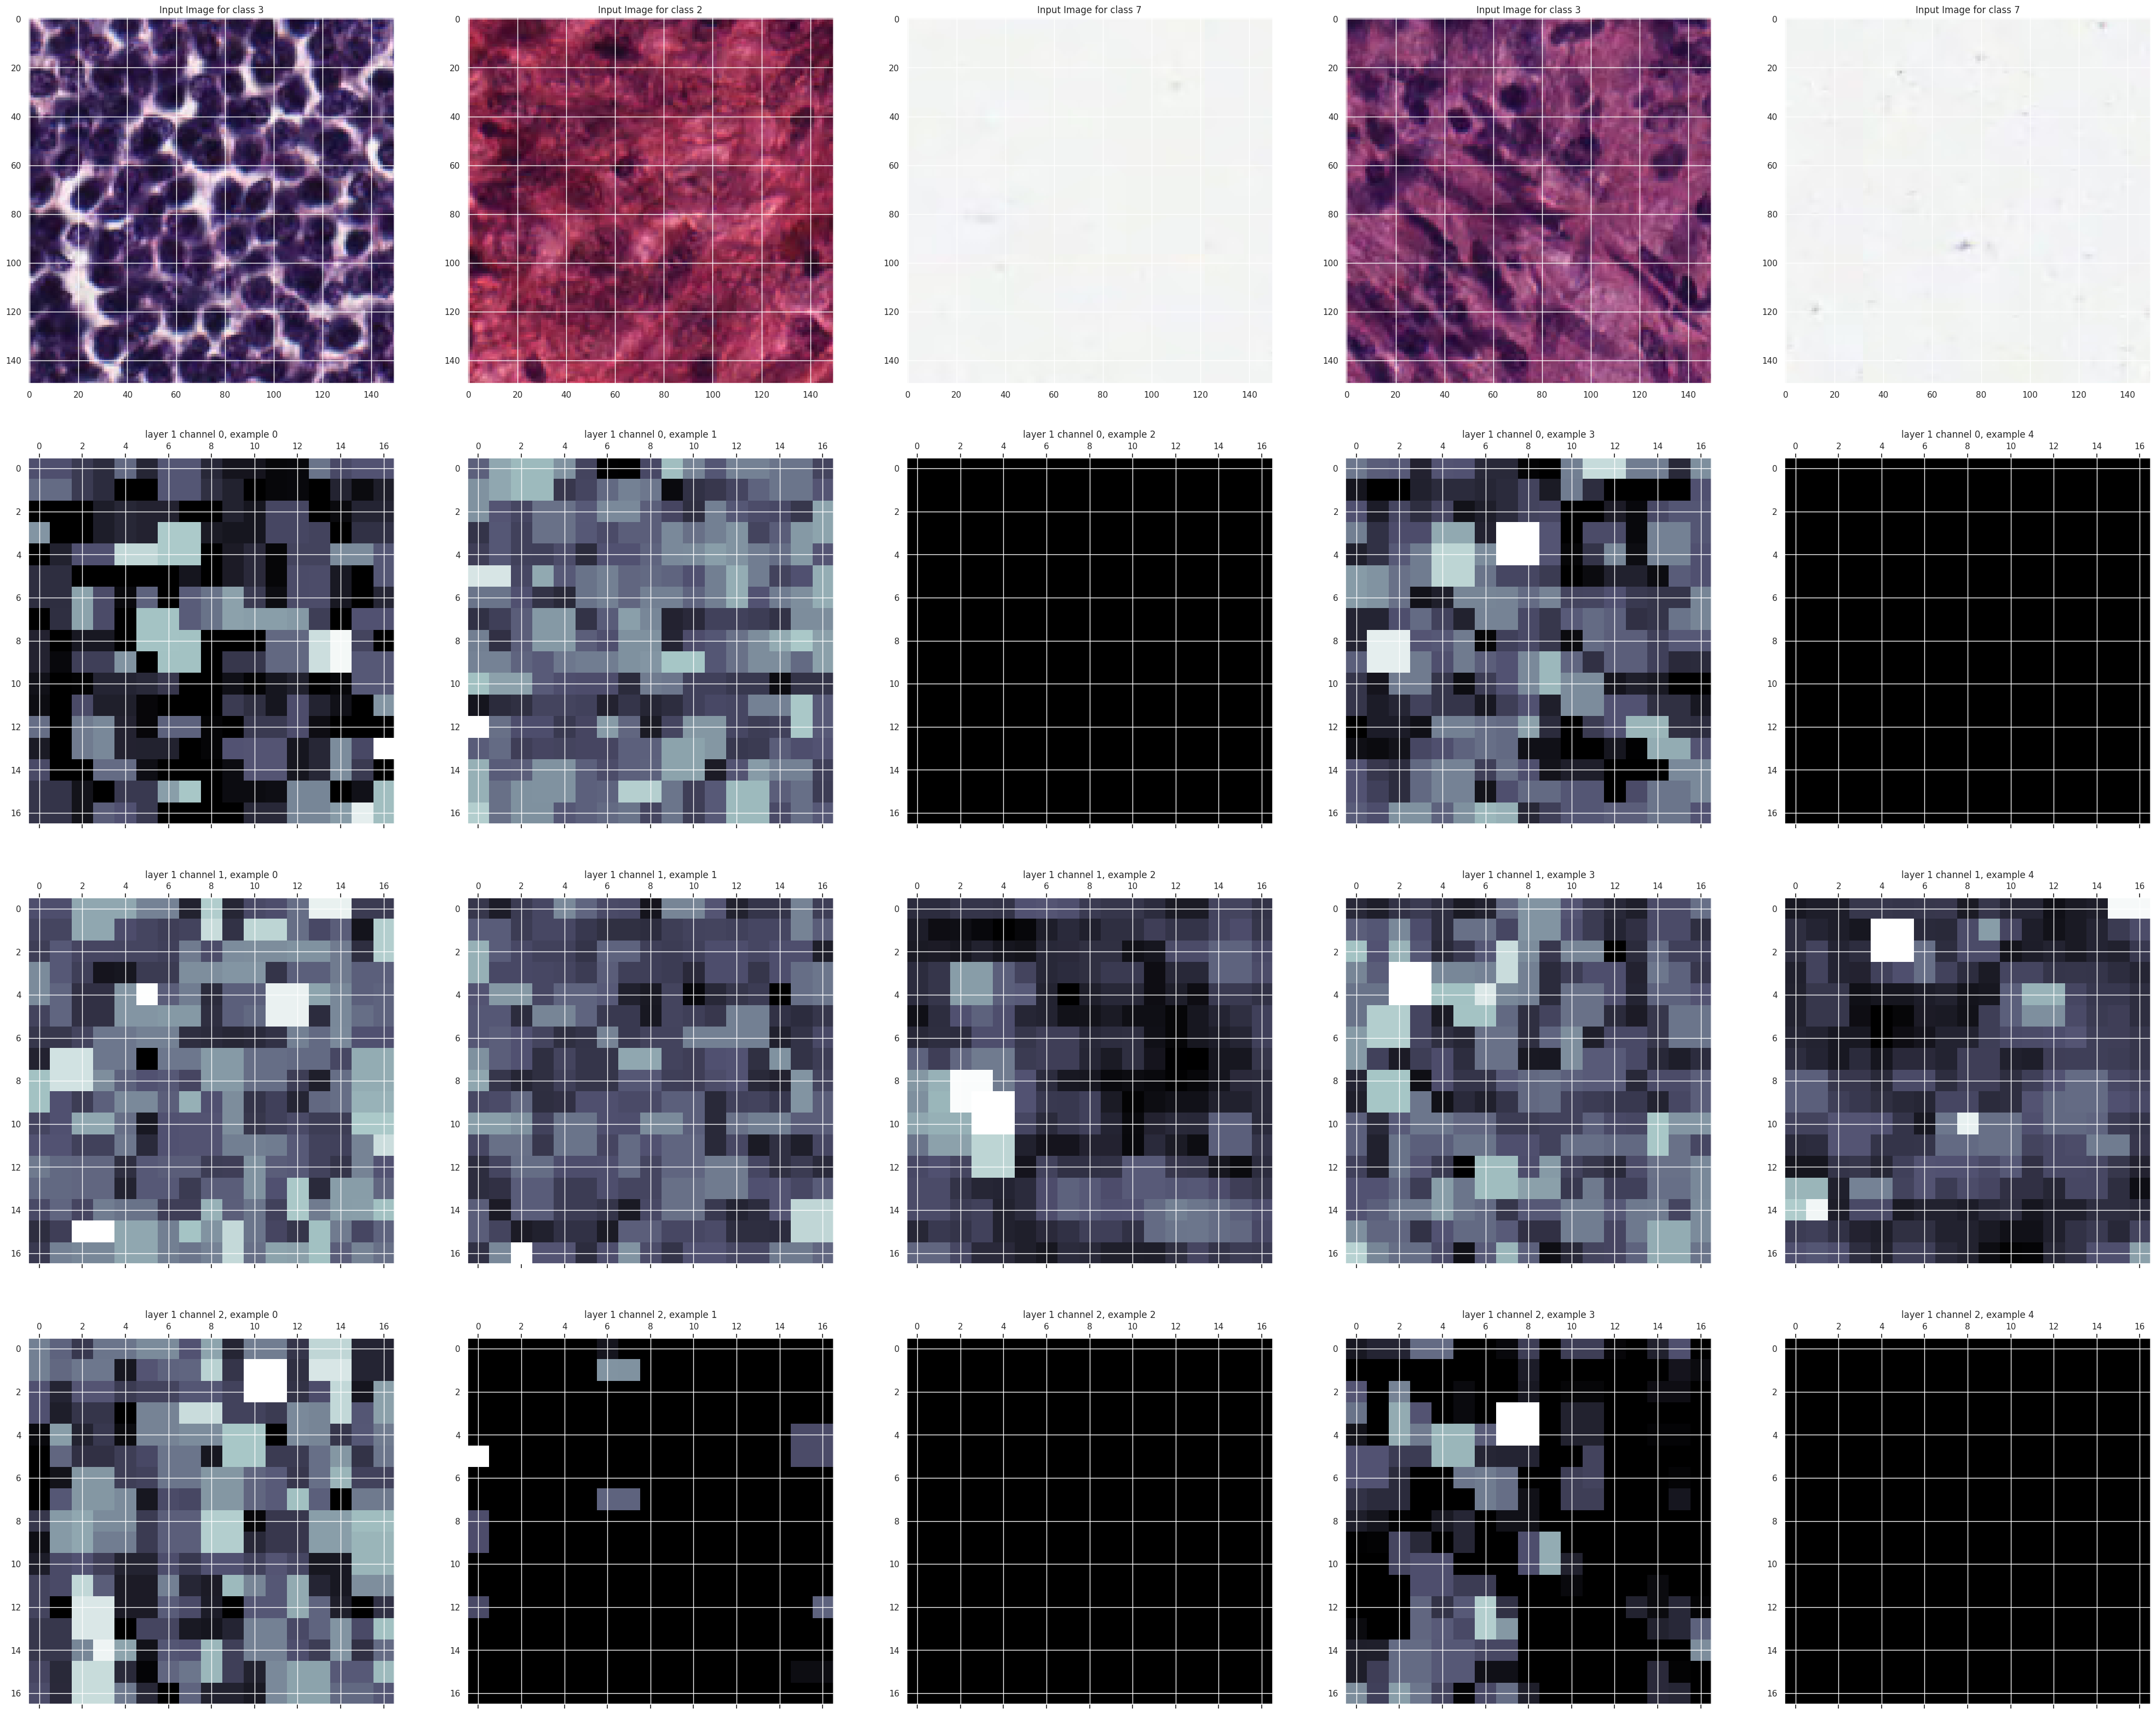

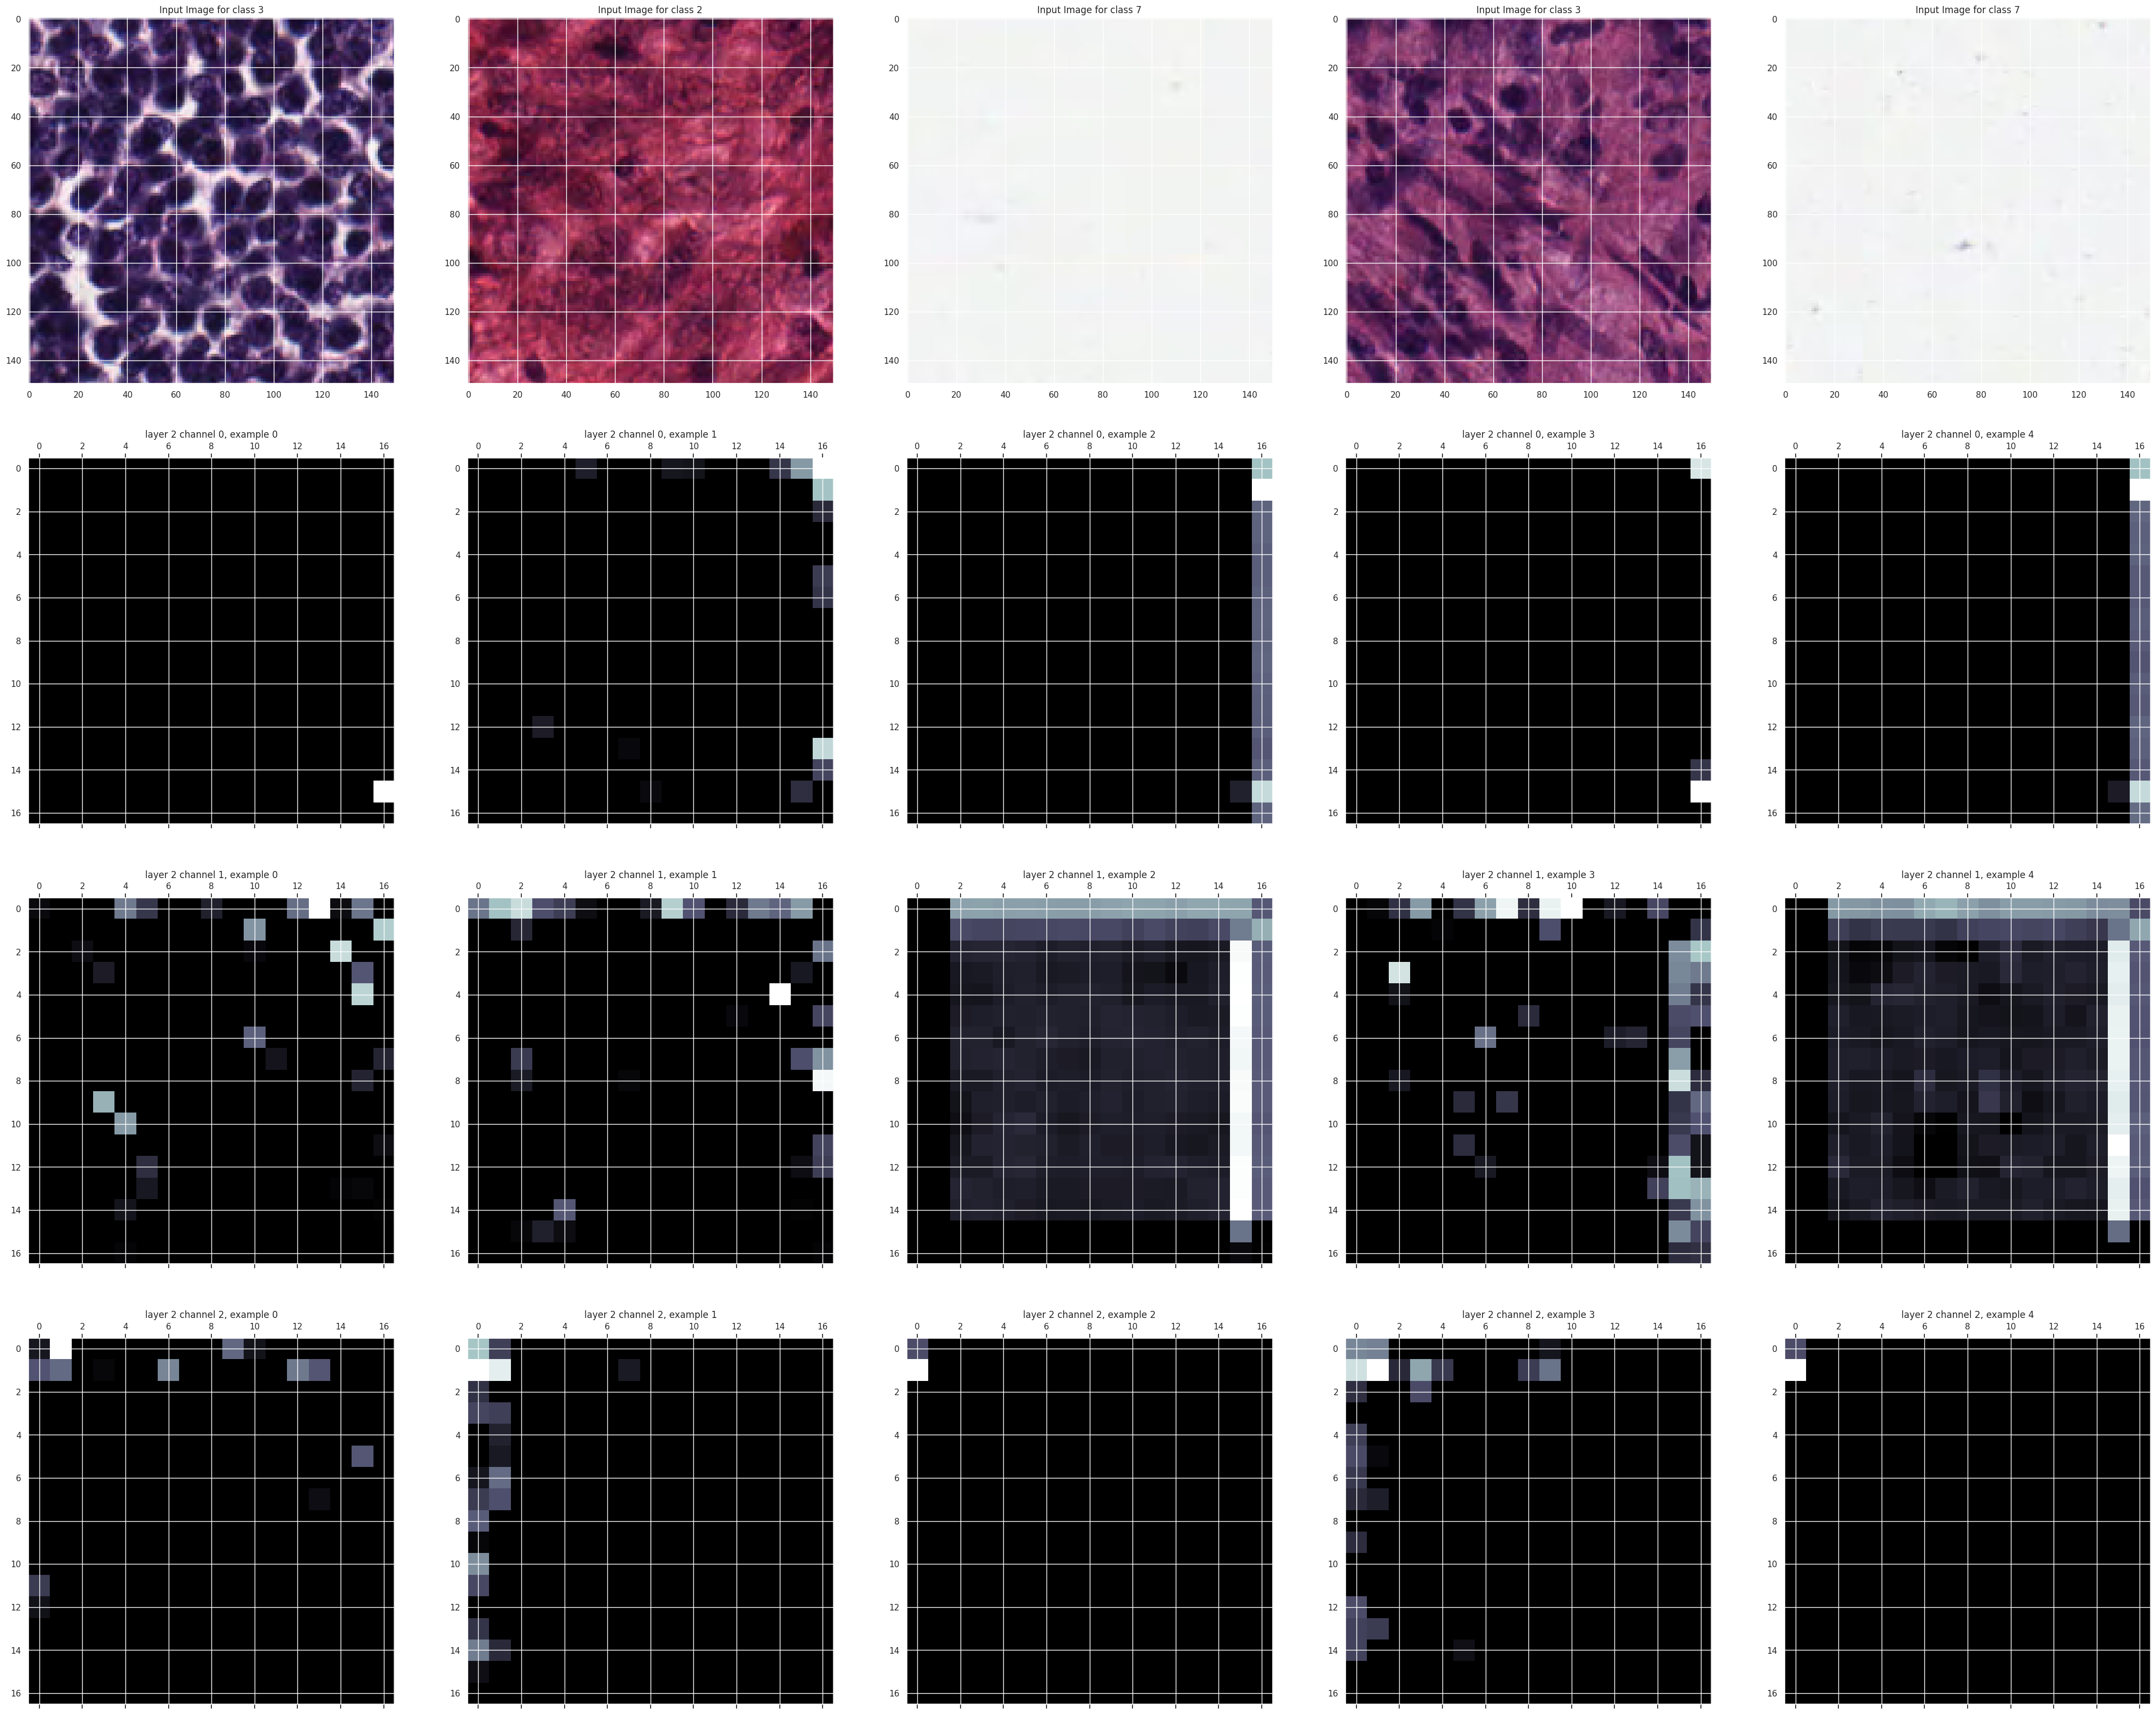

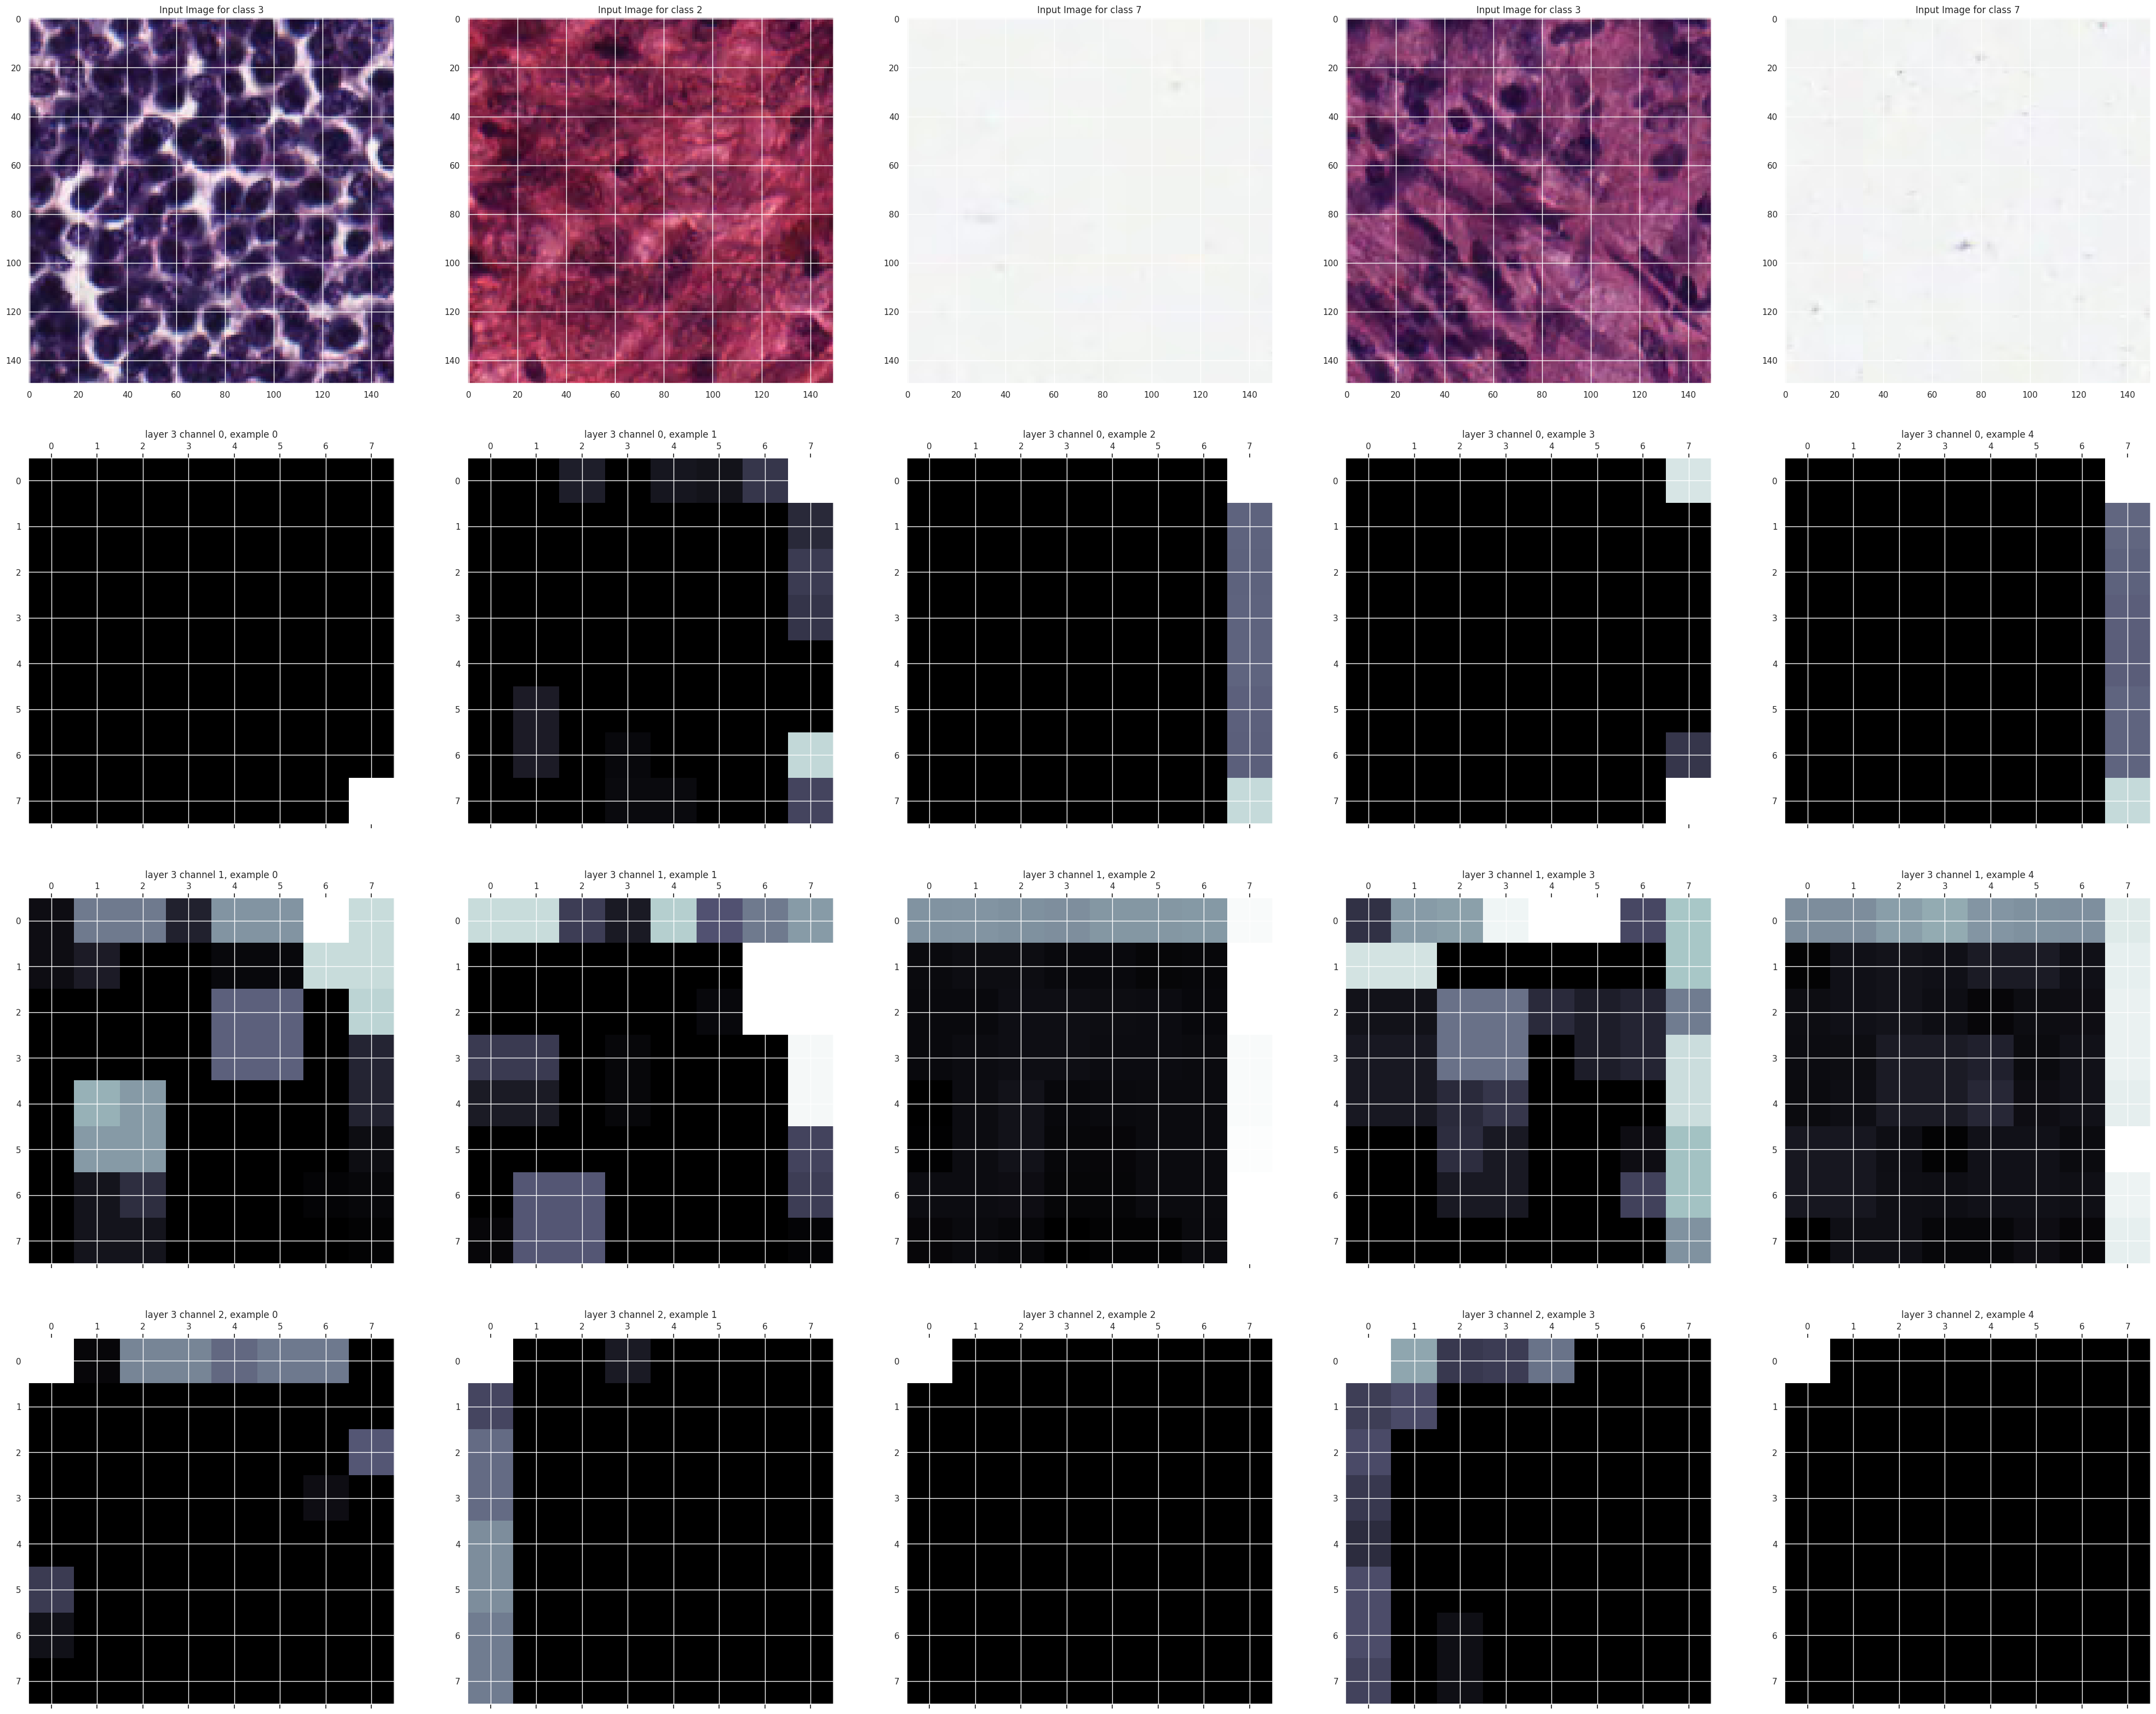

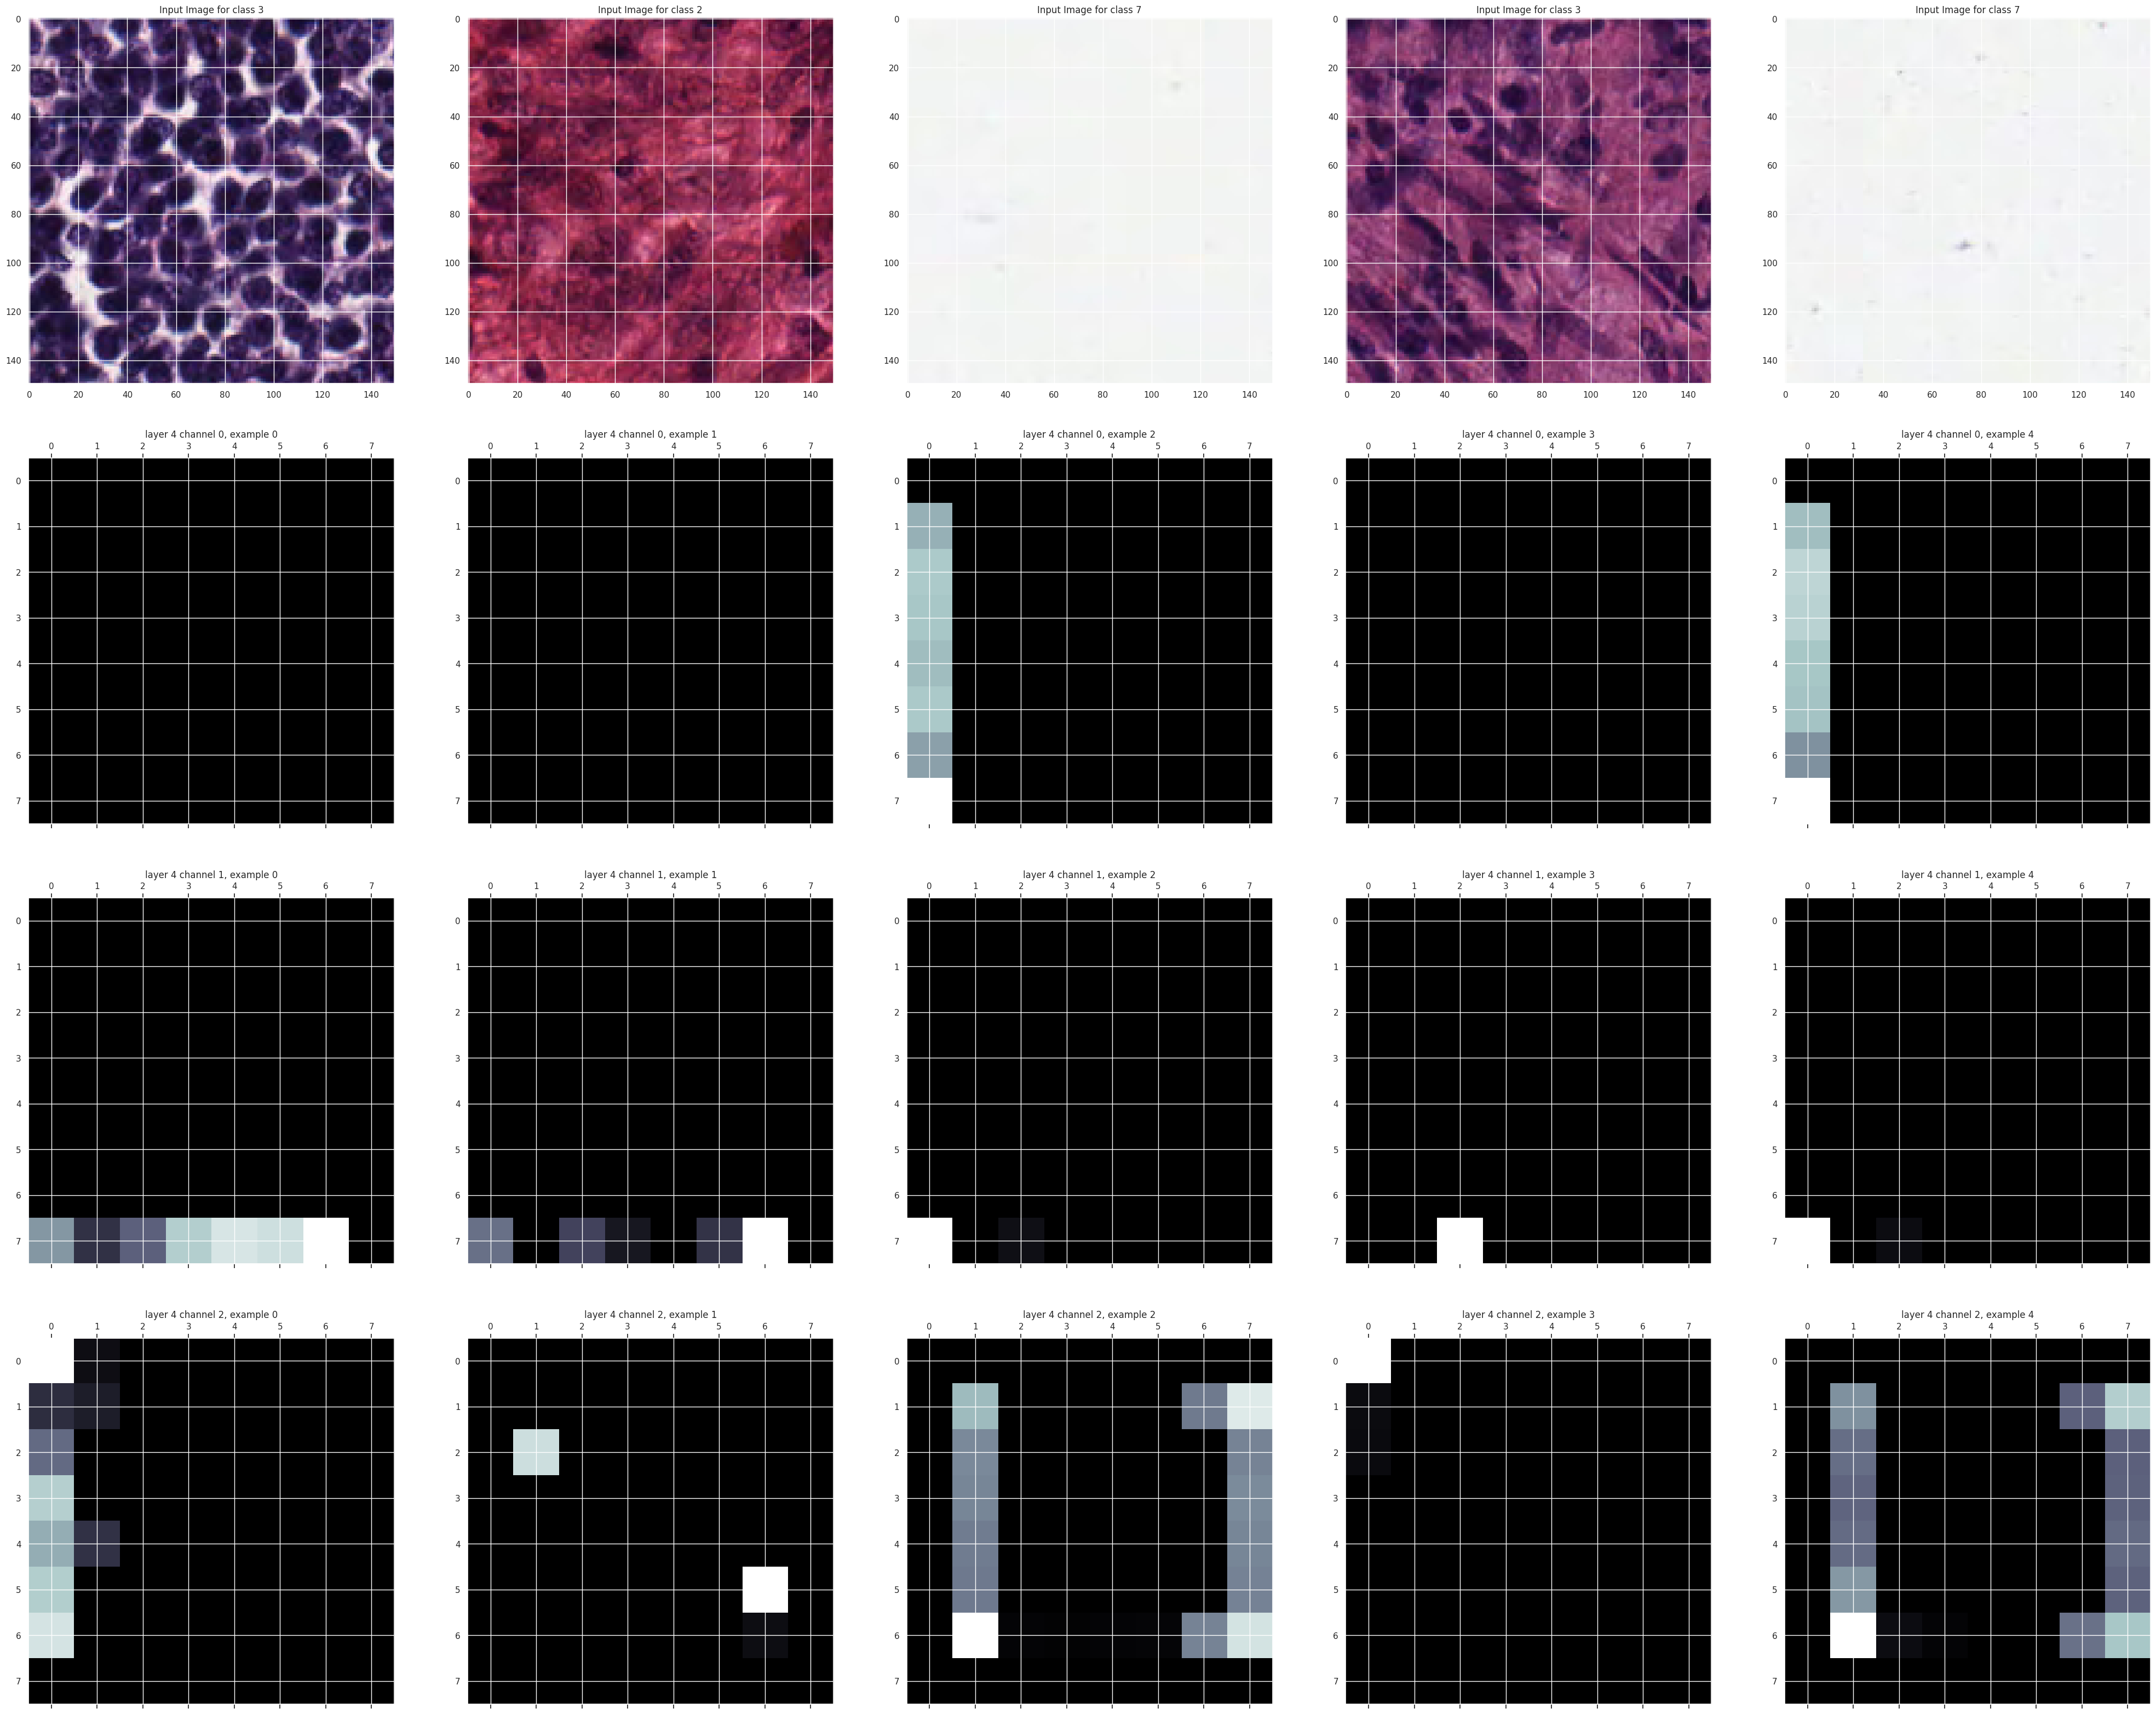

In [19]:
def plot_activations(learning_algo: BaseLearningAlgorithm, num_examples: int, num_layers: int, num_channels: int, ds_test: tf.data.Dataset) -> None:
    """Plots activations for convolutional layers.

    Args:
        learning_algo: an implementation of the BaseLearningAlgorithm
        num_examples: number of example images randomly selected from the dataset
        num_layers: The number of layers to investigate
        num_channels: The number of channels to visualize per layer
        ds_test: Test dataset for obtaining activations
    """

    layer_outputs = [layer.output for layer in learning_algo.layers[:num_layers]]
    activation_model = tf.keras.models.Model(inputs=learning_algo.input, outputs=layer_outputs)

    ds_test_normalized = ds_test.map(normalize_image)

    # Get the activations for the example images.
    for image, label in ds_test_normalized.shuffle(1000).batch(num_examples).take(1):
        activations = activation_model.predict(image)

    for i in range(num_layers):
        activation_layer = activations[i]
        (_, _, _, num_channels_layer) = activations[i].shape

        fig, axs = plt.subplots(nrows=min(num_channels_layer, num_channels) + 1, ncols=num_examples,
                                figsize=(10 * num_examples, 10 * (min(num_channels_layer, num_channels) + 1)))

        for k in range(len(image)):
            axs[0, k].set_title("Input Image for class %d" % label[k])
            axs[0, k].imshow(image[k], cmap='bone')

        for j in range(min(num_channels_layer, num_channels)):
            for k in range(num_examples):
                axs[j + 1, k].set_title("layer %d channel %d, example %d" % (i, j, k))
                axs[j + 1, k].matshow(activation_layer[k, :, :, j], cmap='bone')

    plt.show()
plot_activations(enhanced_classifier, num_examples = 5,num_channels=3, num_layers = 5, ds_test = ds_test)

##Question 5.1 What do the activations tell us about our network?

(a) For a given layer, describe why some activation channels (rows) tend to have stronger responses than other channels. (The strength of a response is visualized by the brightness of the image). Can you describe the textures that a channel is sensitive to? Do any channels have no activation response (all black images)? If so, why?

**Answer:**

In a neural network, some activation channels (rows) tend to have stronger responses than others because they are sensitive to specific features, patterns, or textures in the input data. Such as specific histological features like cell morphology, tissue structures, or visual patterns associated with colorectal cancer.

As said, the strength of a response is visualized by the brightness of the image. Here, white pixels represent the strong positive activations and black pixels represent the strong negative activations.
The textures that a channel is sensitive to are histological features like cell morphology, tissue structures, or visual patterns associated with colorectal cancer and these can be learned during the training process, where the network adjusts its parameters to detect relevant features in the input data.

There are few channels with no activation response i.e., all black images due to the absence of the specific features or patterns or textures as mentioned above which are designed to detect. This could be because the specific features they are sensitive to are not present in the input data or because the network has not yet learned to detect those features effectively.


(b) Describe some differences in the layers. Why are the images getting smaller as the layers increase? What is the relationship between the layer and a receptive field? Why do the images have larger pixels at the higher levels making the image look more "pixelated"?

**Answer:**

Here the enhanced classifier (inspired by LeNet) consists of eight layers, including five convolutional layers, three fully connected layers, and some max-pooling layers.

The convolutional layers are responsible for learning and extracting hierarchical features from the input images and also applies a set of filters to the input image, while the fully connected layers connect all of the neurons in one layer to all of the neurons in the next layer, they are responsible for classifying the input image.
Each pooling layer reduces the size of the feature map by a factor of two.


The images get smaller as the layers increase due to the application of max pooling and convolution within the layers, which reduce the spatial dimensions of the data. This reduction in size allows the neural network to focus on higher-level features and capture them as the data progresses through the layers.

The relationship between the layer and a receptive field is that as the layers progress, the receptive field of the neurons in the network increases.
In this enhanced classifier, the receptive field of a neuron in the network increases with the depth of the network. This means that neurons in deeper layers have a larger receptive field, allowing the network to capture larger and more complex patterns in the input data.


The images have larger pixels at the higher levels, making the image look more "pixelated," due to the reduction in spatial dimensions and the increase in receptive field size. When this spatial dimensions decrease, the resolution of the feature maps also decreases, which results in larger pixels and a more pixelated appearance.


(c) Compare the activations between channels at a layer. Do the channels detect the same textures or do they detect different textures? What enables channels at the same layer to detect different textures?

**Answer:**

At a layer, on comparing the activations between channels, we can observe specific textures and patterns that each channel is sensitive to. By examining the activation maps, we can see that the different features that the network has learned to detect.
On comparing the activations,Few have strong activation response because of the channel with the histological features and patterns like cell morphology, tissue structures, or visual patterns associated with colorectal cancer
and few having no activation response (which are all black-images) which says that they dont.

The channels at the same layer can detect both similar and different textures. Because each channel is associated with a unique filter, and these filters are designed to recognize distinct or specific features. This diversity in feature detection enables the network to capture a wide range of visual information and learn complex representations of the input data.

The use of multiple convolutional filters or kernels enables the ability of channels at the same layer to detect different textures. Each filter is responsible for detecting specific features or patterns. And as a result, different channels within the same layer can specialize in detecting different textures based on the learned filters.



#6. Implement GoogLeNet Inception Architecture.

Review section [D2L Section 7.4](https://classic.d2l.ai/chapter_convolutional-modern/googlenet.html) and implement a GoogLeNet architecture with Inception blocks. Start with the origina architecture, and then make alterations that improve performance. These alterations may include adding more or fewer layers, activation functions, changing parameter number of channels, pooling sizes, etc.)

Epoch 1/10
40/40 [==============================] - 32s 221ms/step - loss: 0.7751 - accuracy: 0.7155 - val_loss: 5.8213 - val_accuracy: 0.2220
Epoch 2/10
40/40 [==============================] - 8s 210ms/step - loss: 0.5102 - accuracy: 0.8127 - val_loss: 2.3838 - val_accuracy: 0.3120
Epoch 3/10
40/40 [==============================] - 8s 210ms/step - loss: 0.4521 - accuracy: 0.8375 - val_loss: 1.7715 - val_accuracy: 0.3880
Epoch 4/10
40/40 [==============================] - 8s 210ms/step - loss: 0.4467 - accuracy: 0.8500 - val_loss: 1.1677 - val_accuracy: 0.5240
Epoch 5/10
40/40 [==============================] - 8s 210ms/step - loss: 0.3819 - accuracy: 0.8737 - val_loss: 0.8190 - val_accuracy: 0.6480
Epoch 6/10
40/40 [==============================] - 8s 209ms/step - loss: 0.3617 - accuracy: 0.8795 - val_loss: 0.7213 - val_accuracy: 0.6720
Epoch 7/10
40/40 [==============================] - 8s 210ms/step - loss: 0.3387 - accuracy: 0.8863 - val_loss: 0.5249 - val_accuracy: 0.7840
Epoch

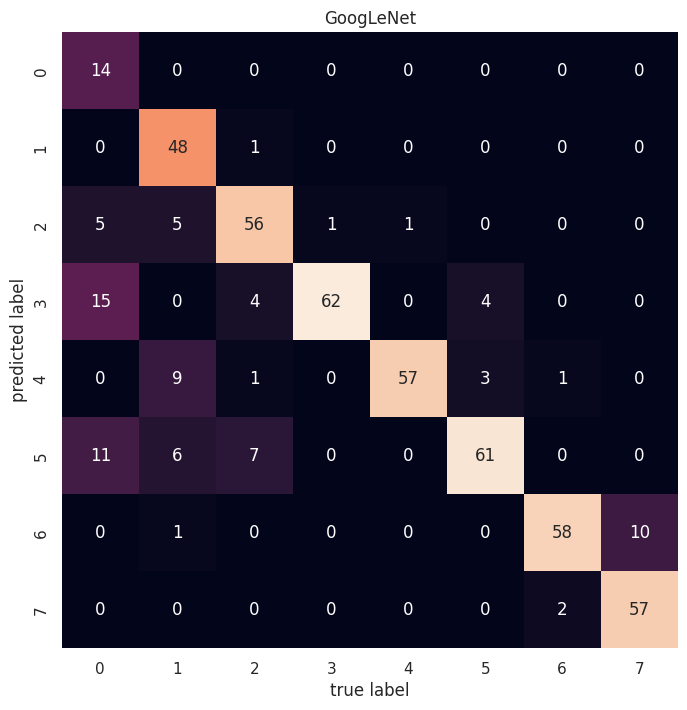

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from typing import Sequence

#Channel last configuration
channel_axis = -1

class GoogLeNet(BaseLearningAlgorithm):
    def __init__(self, num_epochs=10):
        self._num_epochs = num_epochs
        self._model = self._build_model()

    def _build_model(self):
        input_layer = layers.Input(shape=(150, 150, 3))  # Assuming input size of 150x150 RGB images

        # GoogLeNet architecture (simplified)
        x = self._inception_block(input_layer, filters=[64, 128, 32, 32, 32, 32, 32])
        x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        x = self._inception_block(x, filters=[128, 192, 96, 32, 32, 32, 32])
        x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

        # Add more inception blocks as needed

        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(8, activation='softmax')(x)  # Assuming 8 classes for classification

        model = models.Model(inputs=input_layer, outputs=x)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        return model

    def _inception_block(self, x, filters):
        # Simplified Inception block
        branch1x1 = self._conv2d_bn(x, filters[0], 1)

        branch5x5 = self._conv2d_bn(x, filters[1], 1)
        branch5x5 = self._conv2d_bn(branch5x5, filters[2], 5)

        branch3x3dbl = self._conv2d_bn(x, filters[3], 1)
        branch3x3dbl = self._conv2d_bn(branch3x3dbl, filters[4], 3)
        branch3x3dbl = self._conv2d_bn(branch3x3dbl, filters[5], 3)

        branch_pool = layers.AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = self._conv2d_bn(branch_pool, filters[6], 1)

        x = layers.concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool], axis=channel_axis)
        return x

    def _conv2d_bn(self, x, filters, kernel_size):
        x = layers.Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
        x = layers.BatchNormalization(axis=channel_axis)(x)
        return x

    def fit(self, ds_train: tf.data.Dataset, ds_val: tf.data.Dataset) ->  tf.keras.callbacks.History:
        batch_size = 100
        train_batches = ds_train.shuffle(1000).map(map_to_categorical).batch(batch_size)
        val_batches = ds_val.map(map_to_categorical).batch(batch_size)
        history = self._model.fit(train_batches, epochs=self._num_epochs, validation_data=val_batches)
        return history

    def predict(self, x_test:tf.Tensor) :
        return np.argmax(self._model.predict(x_test), axis = 1)

    @property
    def name(self):
        return "GoogLeNet"

    @property
    def layers(self) -> Sequence[tf.keras.layers.Layer]:
        return self._model.layers

    @property
    def input(self):
        return self._model.input

googlenet = GoogLeNet()
%time train_eval(googlenet, ds_train, ds_val, ds_test)

##[OPTIONAL 2% grade points] Adapting the GoogLeNet Architecture

Make a changes to  the original GoogLeNet architecture, such as the number of layers or types of layers that yields a consistent improvement in accuracy. (Not looking for a robust statistical test, just consistent improvement over two or more executions). To gain credit, you must describe your design change and demonstrate improved accuracy over two or more executions.

In [ ]:
# TODO implement GoogLeNet as a subclass of BaseLearningAlgorithm.


##Question 6.1 GoogLeNet performance
(a) What was the overall accuracy and runtime achieved by your implementation of GoogLeNet?

**Answer**

The overall accuracy obtained by GoogLeNet was 0.83 and runtime achieved by it was 1min 29s

(b) Describe which classes generate the most errors based on the confusion matrix.

**Answer**

Top 3 classes making errors:
Class 0 confused with Class 3 (Error Rate: 0.33)
Class 0 confused with Class 5 (Error Rate: 0.24)
Class 7 confused with Class 6 (Error Rate: 0.15)


(c) What was the execution runtime?

**Answer**

The Execution runtime by GoogLeNet was 1min 49s.

(d) How many parameters does your model have?

Total Parameters of the model were 669064.

In [ ]:
googlenet._model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 150, 150, 32)         128       ['input_1[0][0]']             
                                                                                                  
 batch_normalization_3 (Bat  (None, 150, 150, 32)         128       ['conv2d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 conv2d_1 (Conv2D)           (None, 150, 150, 128)        512       ['input_1[0][0]']         

#7. Homework Summary



##Question 7.1 Summary

(a) Create a table of the methods you tried (LeNet, Enhanced Classifier, and GoogLeNet) with the overall accuracies. Which method provided the highest accuracy?

    Method   |     LeNet        |     EnhancedClassifier    |     GoogLeNet |
    ---------|------------------|---------------------------|---------------|
    Accuracy |     0.12         |        0.83               |      0.83     |

Both Enhanced classifier and Googlenet gave the highest accuracy.

But after applying the learning rate scheduler enhanced classifier gave highest which is 0.88 and also googlenet gave 0.89 earlier (but I lost the performance on multiple executions of the code)

(b) Describe which architectural changes (number layers, channel sizes, learning rates, activation functions, etc.) had the strongest influence accuracy?

**Answer**

In Lenet, number of layers, activation functions and channel size has the strongest influence.
* The depth of the network and the arrangement of these layers significantly influences its accuracy.
* The choice of activation functions like the sigmoid activation function in the hidden layers and the softmax activation function in the output layer, these functions plays a crucial role in the model's accuracy.
* The number of channels in the convolutional layers and the fully connected layers impacts the model's capacity to learn hierarchical features from the input data.

In AlexNet same as Lenet, number of layers, activation functions and channel size has the strongest influence.
* The depth and the arrangement of layers contributs to its improved accuracy.
* AlexNet uses the ReLU (Rectified Linear Unit) activation function, which helped mitigate the vanishing gradient problem and contributed to the model's accuracy.
* The number of channels in the convolutional layers and the fully connected layers influences the model's capacity to learn discriminative features from the input data.


In GoogLeNet, number of layers, inception module and 1x1 convolutions influences the most.

* GoogLeNet is a 22-layer deep cnn which is significantly deeper than its predecessors. The increased depth allows the model to learn more complex features, contributing to its accuracy.
* GoogLeNet's inception module, which consists of parallel convolutional pathways with different kernel sizes significantly influences the model's accuracy.
* 1x1 Convolutions used for reducing dimensionality and increasing depth without significantly increasing computational complexity, and it helps in improving the model's accuracy.

(c) Append the number of parameters and execution time for each model. Is the size and execution time correlated with accuracy?

    Method         |    Parameters      |    Execution Time  | Accuracy |
    ---------------|--------------------|--------------------|--------- |
    LeNet          |     2233356        |      6.38s         | 0.12     |
    ---------------|--------------------|--------------------|--------- |
    EnhancedClas   |     30002568       |      27.2s         | 0.83     |
    ---------------|--------------------|--------------------|--------- |
    GoogLeNet      |     669064         |      1min 49s      | 0.83     |
    ---------------------------------------------------------------------


Here, it is quite complex to say whether the size and execution time correlate with accuracy.  Because, EnhancedLeNet and GoogLeNet, which have higher accuracy (0.83), also have a larger number of parameters compared to LeNet, which has a lower accuracy (0.12).

Though lenet is having large number of parameters,  execution time was low and accuracy too.

In the same way, enhanced classifier having large number of parameters with low execution time, having the high accuracy.

Googlenet  having less number of parameters compared to others having high execution time than lenet and enhanced classifier resulted in high accuracy.

So just by looking at size and execution time, we cant decide the model's accuracy.

